In [1]:
# Pipeline Execution Notebook
# Title
# ------
# This Jupyter Notebook demonstrates how to execute a data processing pipeline for astronomical observations.

# Subtitle
# --------
# The pipeline consists of several steps, including rebinning, calibration, subtraction, application of calibration, and imaging.



In [1]:
import time
import logging
import hashlib
import datetime
from steps.imaging import ImagingStep
from steps.pipelinestep import DP3Step
from datasource import InputS3, OutputS3
from util import setup_logging

In [4]:
# Logger setup
LOG_LEVEL = logging.INFO
logger = setup_logging(LOG_LEVEL)

current_time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
run_hash = hashlib.sha256(current_time.encode()).hexdigest()[:10]
logger.info(f"Run Hash: {run_hash}")


def prepend_hash_to_key(base_key):
    return f"{run_hash}/{base_key.strip('/')}"

2024-04-29 09:32:05 [INFO] 3574407716.py:7 -- Run Hash: 5eb6344b4c
2024-04-29 09:32:05 [INFO] Run Hash: 5eb6344b4c


In [5]:
# Rebinning parameters with hash included in the key as a root directory
rebinning_params = {
    "msin": InputS3(
        bucket="ayman-extract",
        key="partitions/partitions_7900_20zip_1",
    ),
    "steps": "[aoflag, avg, count]",
    "aoflag.type": "aoflagger",
    "aoflag.strategy": InputS3(
        bucket="ayman-extract",
        key="parameters/rebinning/STEP1-NenuFAR64C1S.lua",
    ),
    "avg.type": "averager",
    "avg.freqstep": 4,
    "avg.timestep": 8,
    "msout": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("rebinning_out"),
        file_ext="ms",
    ),
    "numthreads": 4,
}

# Calibration parameters with hash included in the key as a root directory
calibration_params = {
    "msin": InputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("rebinning_out"),
    ),
    "msin.datacolumn": "DATA",
    "msout": ".",
    "steps": "[cal]",
    "cal.type": "ddecal",
    "cal.mode": "diagonal",
    "cal.sourcedb": InputS3(
        bucket="ayman-extract",
        key="parameters/calibration/STEP2A-apparent.sourcedb",
    ),
    "cal.h5parm": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/h5"),
        file_ext="h5",
    ),
    "cal.solint": 4,
    "cal.nchan": 4,
    "cal.maxiter": 50,
    "cal.uvlambdamin": 5,
    "cal.smoothnessconstraint": 2e6,
    "numthreads": 4,
    "msout": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/ms"),
        file_ext="ms",
    ),
}

# Subtraction parameters with hash included in the key as a root directory
substraction = {
    "msin": InputS3(bucket="ayman-extract", key=prepend_hash_to_key("applycal_out/ms")),
    "msin.datacolumn": "DATA",
    "msout.datacolumn": "SUBTRACTED_DATA",
    "steps": "[sub]",
    "sub.type": "h5parmpredict",
    "sub.sourcedb": InputS3(
        bucket="ayman-extract",
        key="parameters/calibration/STEP2A-apparent.sourcedb",
    ),
    "sub.directions": "[[CygA],[CasA]]",
    "sub.operation": "subtract",
    "sub.applycal.parmdb": InputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/h5"),
        dynamic=True,
        file_ext="h5",
    ),
    "sub.applycal.steps": "[sub_apply_amp,sub_apply_phase]",
    "sub.applycal.correction": "fulljones",
    "sub.applycal.sub_apply_amp.correction": "amplitude000",
    "sub.applycal.sub_apply_phase.correction": "phase000",
    "msout": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/ms"),
        file_ext="ms",
    ),
}

# Apply calibration parameters with hash included in the key as a root directory
apply_calibration = {
    "msin": InputS3(bucket="ayman-extract", key=prepend_hash_to_key("applycal_out/ms")),
    "msin.datacolumn": "SUBTRACTED_DATA",
    "msout": OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/ms"),
        file_ext="ms",
    ),
    "msout.datacolumn": "CORRECTED_DATA",
    "steps": "[apply]",
    "apply.type": "applycal",
    "apply.steps": "[apply_amp,apply_phase]",
    "apply.apply_amp.correction": "amplitude000",
    "apply.apply_phase.correction": "phase000",
    "apply.direction": "[Main]",
    "apply.parmdb": InputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("applycal_out/h5"),
        dynamic=True,
        file_ext="h5",
    ),
}

# Imaging parameters with hash included in the key as a root directory
imaging_params = [
    "-size",
    "1024",
    "1024",
    "-pol",
    "I",
    "-scale",
    "5arcmin",
    "-niter",
    "100000",
    "-gain",
    "0.1",
    "-mgain",
    "0.6",
    "-auto-mask",
    "5",
    "-local-rms",
    "-multiscale",
    "-no-update-model-required",
    "-make-psf",
    "-auto-threshold",
    "3",
    "-weight",
    "briggs",
    "0",
    "-data-column",
    "CORRECTED_DATA",
    "-nmiter",
    "0",
    "-name",
    OutputS3(
        bucket="ayman-extract",
        key=prepend_hash_to_key("imag_out"),
    ),
]

In [6]:
# Execute Rebinning
start_time = time.time()
finished_job = DP3Step(parameters=rebinning_params, log_level=LOG_LEVEL).run(
    func_limit=1
)
end_time = time.time()
logger.info(f"Rebinning completed in {end_time - start_time} seconds.")

2024-04-29 09:32:09,973 - INFO - S3 client created - Region: None
2024-04-29 09:32:10,013 - INFO - MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-29 09:32:10,056 - INFO - MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-29 09:32:10 [INFO] pipelinestep.py:303 -- Starting step with [[{'msin': InputS3(bucket=ayman-extract, key=partitions/partitions_7900_20zip_1/partition_1.ms.zip, file_ext=None), 'steps': '[aoflag, avg, count]', 'aoflag.type': 'aoflagger', 'aoflag.strategy': InputS3(bucket=ayman-extract, key=parameters/rebinning/STEP1-NenuFAR64C1S.lua, file_ext=None), 'avg.type': 'averager', 'avg.freqstep': 4, 'avg.timestep': 8, 'msout': OutputS3(bucket=ayman-extract, key=5eb6344b4c/rebinning_out, file_ext=ms), 'numthreads': 4}]] 
2024-04-29 09:32:10 [INFO] Starting step with [[{'msin': InputS3(bucket=ayman-extract, key=partitions/partitions_7900_20zip_1/partition_1.ms.zip, file_ext=None), 'steps': '[aoflag, avg, count]', 'aoflag.type': 'aoflagger', 'ao

In [7]:
# Execute Calibration
start_time = time.time()
finished_job = DP3Step(
    parameters=[calibration_params, substraction, apply_calibration],
    log_level=LOG_LEVEL,
).run(func_limit=1)
end_time = time.time()
logger.info(f"Calibration completed in {end_time - start_time} seconds.")

2024-04-29 09:32:46,042 [INFO] aws_s3.py:68 -- S3 client created - Region: None
2024-04-29 09:32:46,056 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-29 09:32:46,082 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-29 09:32:46 [INFO] pipelinestep.py:303 -- Starting step with [[{'msin': InputS3(bucket=ayman-extract, key=5eb6344b4c/rebinning_out/partition_1.ms.zip, file_ext=None), 'msin.datacolumn': 'DATA', 'msout': OutputS3(bucket=ayman-extract, key=5eb6344b4c/applycal_out/ms, file_ext=ms), 'steps': '[cal]', 'cal.type': 'ddecal', 'cal.mode': 'diagonal', 'cal.sourcedb': InputS3(bucket=ayman-extract, key=parameters/calibration/STEP2A-apparent.sourcedb, file_ext=None), 'cal.h5parm': OutputS3(bucket=ayman-extract, key=5eb6344b4c/applycal_out/h5, file_ext=h5), 'cal.solint': 4, 'cal.nchan': 4, 'cal.maxiter': 50, 'cal.uvlambdamin': 5, 'cal.smoothnessconstraint': 2000000.0, 'numthreads': 4}, {'msin': InputS3(bucket

In [8]:
# Execute Imaging
start_time = time.time()
finished_job = ImagingStep(
    input_data_path=InputS3(
        bucket="ayman-extract", key=prepend_hash_to_key("applycal_out/ms")
    ),
    parameters=imaging_params,
    log_level=LOG_LEVEL,
).run()
end_time = time.time()
logger.info(f"Imaging completed in {end_time - start_time} seconds.")

2024-04-29 09:34:17,044 [INFO] config.py:139 -- Lithops v3.1.2 - Python3.10
2024-04-29 09:34:17,067 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-29 09:34:17,115 [INFO] k8s.py:111 -- Kubernetes client created - Namespace: default
2024-04-29 09:34:17,133 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-29 09:34:17,163 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-29 09:34:17,176 [INFO] invokers.py:107 -- ExecutorID 39cd4f-2 | JobID A000 - Selected Runtime: docker.io/ayman321/extract3 - 2000MB
2024-04-29 09:34:17,834 [INFO] invokers.py:172 -- ExecutorID 39cd4f-2 | JobID A000 - Starting function invocation: _execute_step() - Total: 1 activations
2024-04-29 09:34:17,938 [INFO] invokers.py:208 -- ExecutorID 39cd4f-2 | JobID A000 - View execution logs at /tmp/lithops-ayman/logs/39cd4f-2-A000.log
2024-04-29 09:34:17 [INFO] imaging.py:164 -- parameters: ['-size', '1024', '

In [25]:
import lithops

keys = lithops.Storage().list_keys('ayman-extract', prefix='5eb6344b4c/')
logger.info(keys)

# fits image is stored at:
bucket = 'ayman-extract'
key = '5eb6344b4c/imag_out-image.fits'

# Download the file from the storage backend
lithops.Storage().download_file(bucket, key, '/tmp/image.fits')


2024-04-29 11:40:13,001 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-29 11:40:13 [INFO] 1574764548.py:4 -- ['5eb6344b4c/applycal_out/h5/partition_1.h5.zip', '5eb6344b4c/applycal_out/ms/partition_1.ms.zip', '5eb6344b4c/imag_out-image.fits', '5eb6344b4c/rebinning_out/partition_1.ms.zip']
2024-04-29 11:40:13 [INFO] ['5eb6344b4c/applycal_out/h5/partition_1.h5.zip', '5eb6344b4c/applycal_out/ms/partition_1.ms.zip', '5eb6344b4c/imag_out-image.fits', '5eb6344b4c/rebinning_out/partition_1.ms.zip']


2024-04-29 11:40:13,033 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000


True

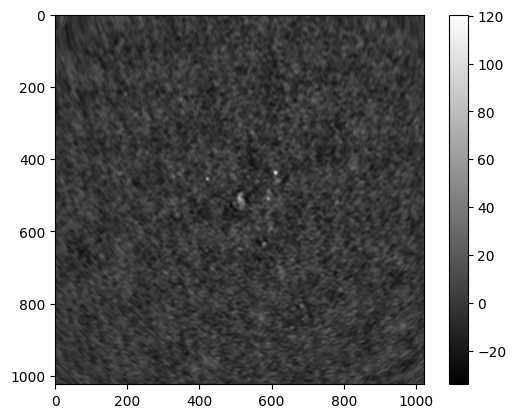

In [26]:
from astropy.io import fits
import matplotlib.pyplot as plt

# Specify the path to the .fits file
fits_file_path = '/tmp/image.fits'

# Open the .fits file
image_data = fits.getdata(fits_file_path)

# Adjust the image_data to reduce its dimensionality to 2D
image_data_2d = image_data[0, 0, :, :]

# Now use plt.imshow on the 2D image data
plt.imshow(image_data_2d, cmap='gray')
plt.colorbar()
plt.show()
